# Global Solution - SmartEnergy - Chatbot & IA

### Integrantes
- Giovanna Revito Roz - RM558981
- Kaian Gustavo de Oliveira Nascimento - RM558986
- Lucas Kenji Kikuchi - RM554424

## Dataset Escolhido - World Energy Consumption

- Link do Dataset no Kaggle: https://www.kaggle.com/datasets/pralabhpoudel/world-energy-consumption/data
- Link do Codebook para informação sobre as variáveis: https://github.com/owid/energy-data/blob/master/owid-energy-codebook.csv

Com este dataset, podemos obter informações como a produção de energia por fontes renováveis e não renováveis, e entender como a proporção delas pode afetar diretamente na emissão de carbono em nosso planeta. Além disso, podemos ter uma métrica de quais continentes podem estar impactando o mundo com emissões indevidas pela produção de energia com predominância de fontes não renováveis.

## Importação das Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.impute import KNNImputer

## Análise Exploratória dos Dados (AED)

Pegando dataset 'World Energy Consumption'

In [2]:
df = pd.read_csv("World Energy Consumption.csv")
df

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22007,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,NaN,NaN,NaN,NaN,25.910,...,0.218,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22008,Zimbabwe,2019,ZWE,15354606.0,NaN,NaN,NaN,NaN,NaN,24.748,...,0.364,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22009,Zimbabwe,2020,ZWE,15669663.0,NaN,NaN,NaN,NaN,NaN,22.336,...,0.395,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN
22010,Zimbabwe,2021,ZWE,15993525.0,NaN,NaN,NaN,NaN,NaN,23.760,...,0.498,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN


Removendo registros que não se enquadram como países/ilhas

In [3]:
df = df[df['iso_code'].notna() & df['population'].notna()]

Selecionando as variáveis de interesse
- country: País
- year: Ano
- population: População por País
- coal_electricity: eletricidade gerada por carvão (em terawatt-horas)
- biofuel_electricity: eletricidade gerada por biocombustíveis (em terawatt-horas)
- fossil_electricity: eletricidade gerada por combustíveis fóssil (em terawatt-horas)
- gas_electricity: eletricidade gerada por gases naturais (em terawatt-horas)
- hydro_electricity: eletricidade gerada por hidrelétricas (em terawatt-horas)
- nuclear_electricity: eletricidade gerada por usinas nucleares (em terawatt-horas)
- oil_electricity: eletricidade gerada por óleo (em terawatt-horas)
- other_renewable_exc_biofuel_electricity: eletricidade gerada por outras  fontes renováveis (geotérmica, maré etc), excluindo biocombustíveis (em terawatt-horas)
- solar_electricity: eletricidade gerada por painéis solares (em terawatt-horas)
- wind_electricity: eletricidade gerada por energia eólica (em terawatt-horas)
- electricity_generation: total de energia gerada no ano (em terawatt-horas)
- greenhouse_gas_emissions: emissões de carbono (em milhões de toneladas de CO2)

In [4]:
df=df[['country','year', 'population', 'coal_electricity',
       'biofuel_electricity','fossil_electricity', 'gas_electricity', 'hydro_electricity',
        'nuclear_electricity', 'oil_electricity', 'other_renewable_exc_biofuel_electricity',
       'solar_electricity', 'wind_electricity', 'electricity_generation', 'greenhouse_gas_emissions']]

Removendo registro anteriores a 1990 (Nulos) e registros de 2022 (Nulos também)

In [5]:
df = df[(df['year'] >= 1990) & (df['year'] <= 2021)]

Separando os países em Continentes

In [6]:
continentes = {
   "Ásia": [
    "Afghanistan",
    "Armenia",
    "Azerbaijan",
    "Bangladesh",
    "Bhutan",
    "Brunei",
    "Cambodia",
    "China",
    "East Timor",
    "Georgia",
    "Hong Kong",
    "India",
    "Indonesia",
    "Iran",
    "Iraq",
    "Israel",
    "Japan",
    "Jordan",
    "Kazakhstan",
    "Kyrgyzstan",
    "Laos",
    "Lebanon",
    "Malaysia",
    "Maldives",
    "Mongolia",
    "Myanmar",
    "Nepal",
    "North Korea",
    "Oman",
    "Pakistan",
    "Palestine",
    "Philippines",
    "Qatar",
    "Russia",
    "Saudi Arabia",
    "Singapore",
    "South Korea",
    "Sri Lanka",
    "Syria",
    "Taiwan",
    "Tajikistan",
    "Thailand",
    "Turkmenistan",
    "United Arab Emirates",
    "Uzbekistan",
    "Vietnam",
    "Yemen",
    'Bahrain', 'Kuwait', 'Macao'

],

"África": [
    "Algeria",
    "Angola",
    "Benin",
    "Botswana",
    "Burkina Faso",
    "Burundi",
    "Cameroon",
    "Cape Verde",
    "Central African Republic",
    "Chad",
    "Comoros",
    "Congo",
    "Cote d'Ivoire",
    "Democratic Republic of Congo",
    "Djibouti",
    "Egypt",
    "Equatorial Guinea",
    "Eritrea",
    "Eswatini",
    "Ethiopia",
    "Gabon",
    "Gambia",
    "Ghana",
    "Guinea",
    "Guinea-Bissau",
    "Ivory Coast",
    "Kenya",
    "Lesotho",
    "Liberia",
    "Libya",
    "Madagascar",
    "Malawi",
    "Mali",
    "Mauritania",
    "Mauritius",
    "Morocco",
    "Mozambique",
    "Namibia",
    "Niger",
    "Nigeria",
    "Rwanda",
    "Sao Tome and Principe",
    "Senegal",
    "Seychelles",
    "Sierra Leone",
    "Somalia",
    "South Africa",
    "South Sudan",
    "Sudan",
    "Tanzania",
    "Togo",
    "Tunisia",
    "Uganda",
    "Western Sahara",
    "Zambia",
    "Zimbabwe",
],
"Américas": [
    "Antigua and Barbuda",
    "Bahamas",
    "Barbados",
    "Belize",
    "Canada",
    "Costa Rica",
    "Cuba",
    "Dominica",
    "Dominican Republic",
    "El Salvador",
    "Grenada",
    "Guatemala",
    "Haiti",
    "Honduras",
    "Jamaica",
    "Mexico",
    "Nicaragua",
    "Panama",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Saint Vincent and the Grenadines",
    "Trinidad and Tobago",
    "United States",
    "United States Virgin Islands",
    "Argentina",
    "Bolivia",
    "Brazil",
    "Chile",
    "Colombia",
    "Ecuador",
    "Guyana",
    "Paraguay",
    "Peru",
    "Suriname",
    "Uruguay",
    "Venezuela", 'Greenland', 'French Guiana'
],
"Europa": [
    "Albania",
    "Andorra",
    "Armenia",
    "Austria",
    "Azerbaijan",
    "Belarus",
    "Belgium",
    "Bosnia and Herzegovina",
    "Bulgaria",
    "Croatia",
    "Cyprus",
    "Czech Republic",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Georgia",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Ireland",
    "Italy",
    "Latvia",
    "Liechtenstein",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Moldova",
    "Monaco",
    "Montenegro",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "San Marino",
    "Serbia",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    "Turkey",
    "Ukraine",
    "United Kingdom",
    "Vatican City",
    'Czechia', 'Faroe Islands', 'Gibraltar'
],
"Oceania": [
    "Australia",
    "Fiji",
    "Kiribati",
    "Marshall Islands",
    "Micronesia",
    "Nauru",
    "New Zealand",
    "Palau",
    "Papua New Guinea",
    "Samoa",
    "Solomon Islands",
    "Tonga",
    "Tuvalu",
    "Vanuatu",
    'American Samoa', 'Cook Islands', 'French Polynesia', 'Guam', 'Micronesia (country)',
    'New Caledonia', 'Niue', 'Northern Mariana Islands', 'Reunion'
]
}

def map_continent(pais):
    for continente, paises in continentes.items():
        if pais in paises:
            return continente
    return "Unknown"

df['continent'] = df['country'].apply(map_continent)
df = df[df["continent"] != "Unknown"]
df

,country,year,population,coal_electricity,biofuel_electricity,fossil_electricity,gas_electricity,hydro_electricity,nuclear_electricity,oil_electricity,other_renewable_exc_biofuel_electricity,solar_electricity,wind_electricity,electricity_generation,greenhouse_gas_emissions,continent
113,Afghanistan,1990,10694804.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ásia
114,Afghanistan,1991,10745168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ásia
115,Afghanistan,1992,12057436.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ásia
116,Afghanistan,1993,14003764.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ásia
117,Afghanistan,1994,15455560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ásia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22006,Zimbabwe,2017,14751101.0,3.02,0.32,3.05,0.0,3.97,0.0,0.03,0.0,0.01,0.0,7.35,2.67,África
22007,Zimbabwe,2018,15052191.0,3.69,0.39,3.73,0.0,5.05,0.0,0.04,0.0,0.02,0.0,9.19,3.27,África
22008,Zimbabwe,2019,15354606.0,3.62,0.38,3.66,0.0,4.17,0.0,0.04,0.0,0.03,0.0,8.24,3.19,África
22009,Zimbabwe,2020,15669663.0,3.36,0.35,3.40,0.0,3.81,0.0,0.04,0.0,0.03,0.0,7.59,2.96,África


Colunas a serem utilizadas

In [7]:
print(df.columns)

Index(['country', 'year', 'population', 'coal_electricity',
       'biofuel_electricity', 'fossil_electricity', 'gas_electricity',
       'hydro_electricity', 'nuclear_electricity', 'oil_electricity',
       'other_renewable_exc_biofuel_electricity', 'solar_electricity',
       'wind_electricity', 'electricity_generation',
       'greenhouse_gas_emissions', 'continent'],
      dtype='object')


Informações sobre o DataFrame

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6487 entries, 113 to 22010
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country                                  6487 non-null   object 
 1   year                                     6487 non-null   int64  
 2   population                               6487 non-null   float64
 3   coal_electricity                         4952 non-null   float64
 4   biofuel_electricity                      4710 non-null   float64
 5   fossil_electricity                       4994 non-null   float64
 6   gas_electricity                          4952 non-null   float64
 7   hydro_electricity                        5192 non-null   float64
 8   nuclear_electricity                      5081 non-null   float64
 9   oil_electricity                          4952 non-null   float64
 10  other_renewable_exc_biofuel_electricity  4618 non-

Verificando presença de valores Nulos

In [9]:
df.isna().sum()

,0
country,0
year,0
population,0
coal_electricity,1535
biofuel_electricity,1777
fossil_electricity,1493
gas_electricity,1535
hydro_electricity,1295
nuclear_electricity,1406
oil_electricity,1535


Completando valores nulos com a ajuda do KNNImputer

In [10]:
# Separa as colunas numéricas e categóricas
num_cols = df.select_dtypes(include=['float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

imputer = KNNImputer(n_neighbors=5)

# Imputa as colunas numéricas
df = df.copy()
df[num_cols] = imputer.fit_transform(df[num_cols])

Verificando se os valores nulos foram reajustados

In [11]:
df.isna().sum()

,0
country,0
year,0
population,0
coal_electricity,0
biofuel_electricity,0
fossil_electricity,0
gas_electricity,0
hydro_electricity,0
nuclear_electricity,0
oil_electricity,0


Descrição das Variáveis

In [12]:
df.describe()

,year,population,coal_electricity,biofuel_electricity,fossil_electricity,gas_electricity,hydro_electricity,nuclear_electricity,oil_electricity,other_renewable_exc_biofuel_electricity,solar_electricity,wind_electricity,electricity_generation,greenhouse_gas_emissions
count,6487.000000,6.487000e+03,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000,6487.000000
mean,2005.605519,3.256346e+07,36.873731,1.473957,63.049563,20.319051,16.096158,14.193508,5.862092,0.517171,0.757421,2.061449,95.140127,41.634980
std,9.211928,1.269624e+08,243.716779,6.501533,296.482934,80.801290,65.534173,71.245375,18.431974,2.419174,8.102643,18.026243,419.971762,216.626773
min,1990.000000,1.833000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1998.000000,1.139146e+06,0.000000,0.000000,0.342000,0.000000,0.020000,0.000000,0.110000,0.000000,0.000000,0.000000,1.020000,0.300000
50%,2006.000000,6.237984e+06,0.000000,0.012000,3.980000,0.590000,1.160000,0.000000,0.838000,0.000000,0.000000,0.000000,10.048000,2.900000
75%,2014.000000,2.127394e+07,5.975000,0.360000,28.130000,11.035000,7.935000,0.000000,3.860000,0.000000,0.016000,0.060000,46.205000,17.075000
max,2021.000000,1.425894e+09,5339.140000,169.930000,5623.990000,1624.170000,1321.710000,809.410000,287.538000,19.160000,327.000000,655.600000,8484.020000,4618.320000


### Gráficos

Gráfico 1: Visualizando a quantidade de energia produzida pelo Estados Unidos, podemos perceber que a maior parte de sua energia é proveniente de fontes não renováveis até os dias de hoje. Porém, a partir da segunda metade da década de 2000, percebemos um crescimento da produção de energia através de fontes renováveis, como a energia solar e energia eólica, e uma redução na energia produzida por carvão, o que auxiliou na redução da emissão de carbono ao decorrer dos anos.

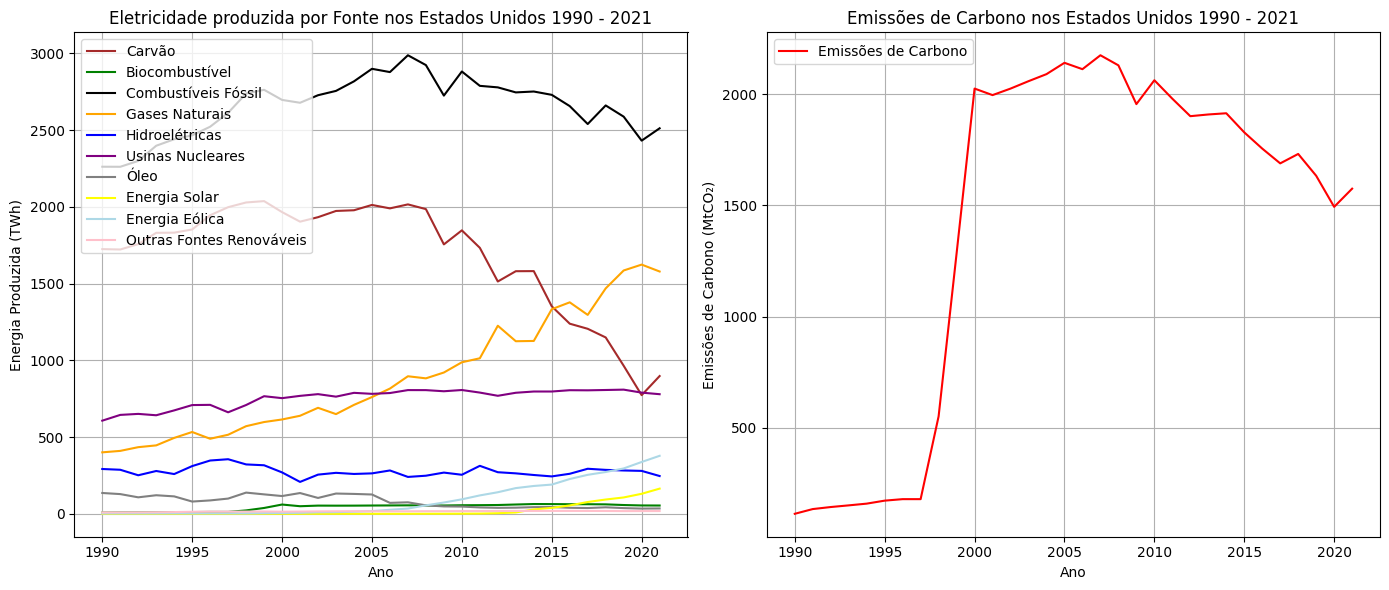

In [13]:
df_usa = df[df['country'] == 'United States']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df_usa['year'], df_usa['coal_electricity'], label='Carvão', color='brown')
plt.plot(df_usa['year'], df_usa['biofuel_electricity'], label='Biocombustível', color='green')
plt.plot(df_usa['year'], df_usa['fossil_electricity'], label='Combustíveis Fóssil', color='black')
plt.plot(df_usa['year'], df_usa['gas_electricity'], label='Gases Naturais', color='orange')
plt.plot(df_usa['year'], df_usa['hydro_electricity'], label='Hidroelétricas', color='blue')
plt.plot(df_usa['year'], df_usa['nuclear_electricity'], label='Usinas Nucleares', color='purple')
plt.plot(df_usa['year'], df_usa['oil_electricity'], label='Óleo', color='grey')
plt.plot(df_usa['year'], df_usa['solar_electricity'], label='Energia Solar', color='yellow')
plt.plot(df_usa['year'], df_usa['wind_electricity'], label='Energia Eólica', color='lightblue')
plt.plot(df_usa['year'], df_usa['other_renewable_exc_biofuel_electricity'], label='Outras Fontes Renováveis', color='pink')
plt.xlabel('Ano')
plt.ylabel('Energia Produzida (TWh)')
plt.title('Eletricidade produzida por Fonte nos Estados Unidos 1990 - 2021')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df_usa['year'], df_usa['greenhouse_gas_emissions'], color='red', label='Emissões de Carbono')
plt.xlabel('Ano')
plt.ylabel('Emissões de Carbono (MtCO₂)')
plt.title('Emissões de Carbono nos Estados Unidos 1990 - 2021')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

Se compararmos os Estados Unidos com a Costa Rica, que passou por uma transição energética por completo, vemos que a curva de diminuição de emissões de carbono é muito mais significativa. Até os anos 2000, a Costa Rica produzia muita energia a partir de fontes não renováveis, como os combustíveis fósseis e gases naturais. A partir de 2000, a Costa Rica passou por uma transição energética extensiva, focando apenas em fontes de energia renováveis, investindo em hidrelétricas, painéis solares e moinhos eólicos, transformando sua produção de energia quase 100% renovável.

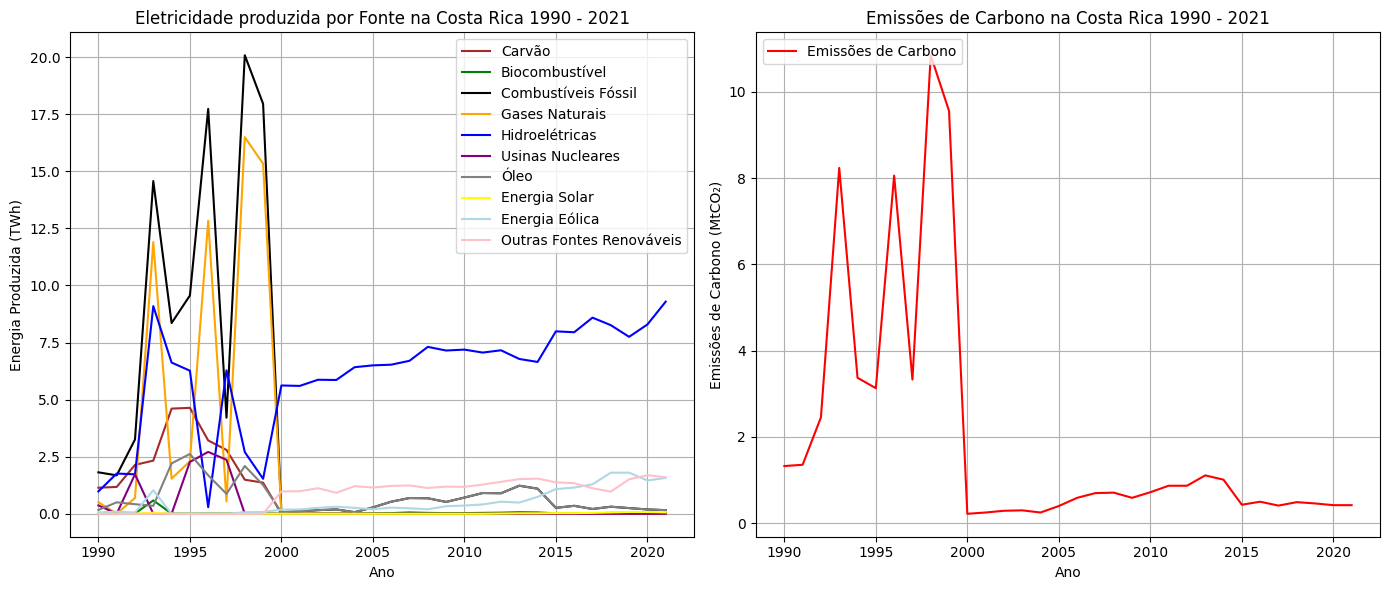

In [14]:
df_costa = df[df['country'] == 'Costa Rica']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df_costa['year'], df_costa['coal_electricity'], label='Carvão', color='brown')
plt.plot(df_costa['year'], df_costa['biofuel_electricity'], label='Biocombustível', color='green')
plt.plot(df_costa['year'], df_costa['fossil_electricity'], label='Combustíveis Fóssil', color='black')
plt.plot(df_costa['year'], df_costa['gas_electricity'], label='Gases Naturais', color='orange')
plt.plot(df_costa['year'], df_costa['hydro_electricity'], label='Hidroelétricas', color='blue')
plt.plot(df_costa['year'], df_costa['nuclear_electricity'], label='Usinas Nucleares', color='purple')
plt.plot(df_costa['year'], df_costa['oil_electricity'], label='Óleo', color='grey')
plt.plot(df_costa['year'], df_costa['solar_electricity'], label='Energia Solar', color='yellow')
plt.plot(df_costa['year'], df_costa['wind_electricity'], label='Energia Eólica', color='lightblue')
plt.plot(df_costa['year'], df_costa['other_renewable_exc_biofuel_electricity'], label='Outras Fontes Renováveis', color='pink')
plt.xlabel('Ano')
plt.ylabel('Energia Produzida (TWh)')
plt.title('Eletricidade produzida por Fonte na Costa Rica 1990 - 2021')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df_costa['year'], df_costa['greenhouse_gas_emissions'], color='red', label='Emissões de Carbono')
plt.xlabel('Ano')
plt.ylabel('Emissões de Carbono (MtCO₂)')
plt.title('Emissões de Carbono na Costa Rica 1990 - 2021')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

Gráfico 2: se tomarmos a Islândia como exemplo, percebemos que sua produção energética é baseada 100% em energia renovável, sendo cerca de 70% proveniente de hidrelétricas, e 30% de outras fontes renováveis (muito provavelmente geotérmica). O Brasil, outro líder em produção de energia renovável, possui como maior produtora de energia as hidrelétricas, tendo um aumento de outras, como a energia solar e a eólica nos últimos anos. A China e a Russia, por outro lado, mantiveram a utilização de energias não renováveis, como combustíveis fósseis e carvão. Por mais que sejam uma das maiores potências do mundo, a conscientização com o planeta não reflete o mesmo.

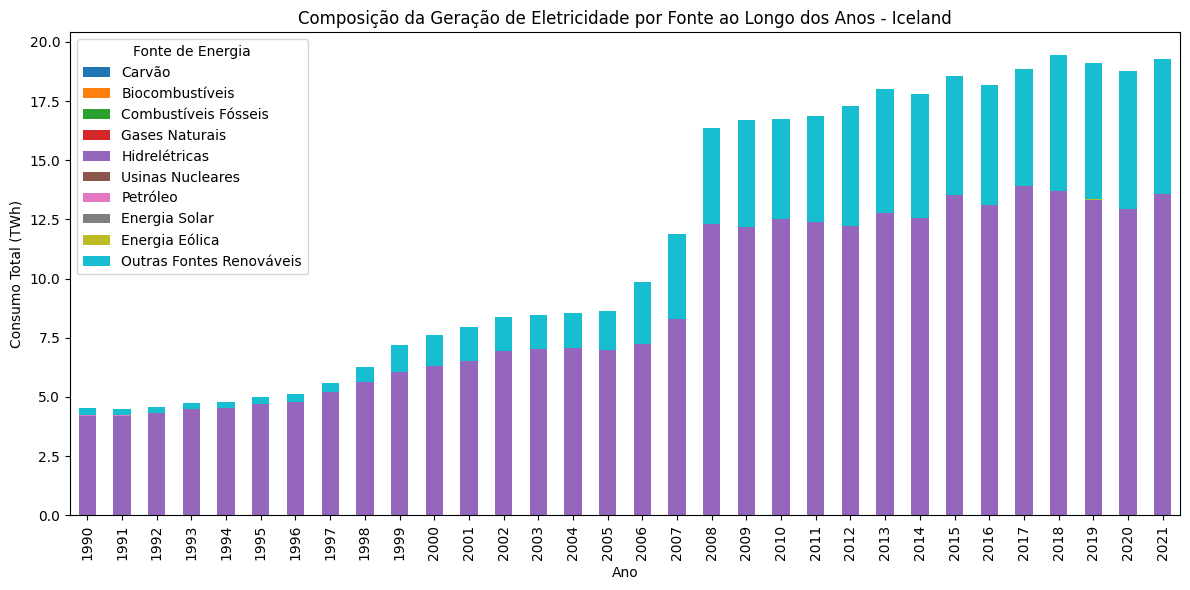

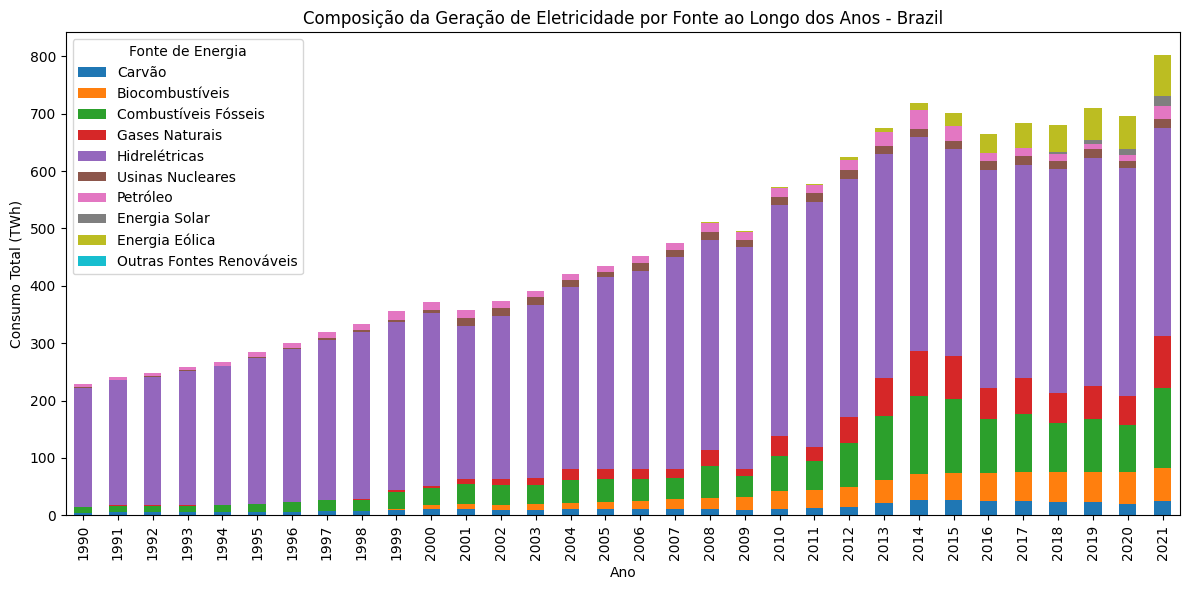

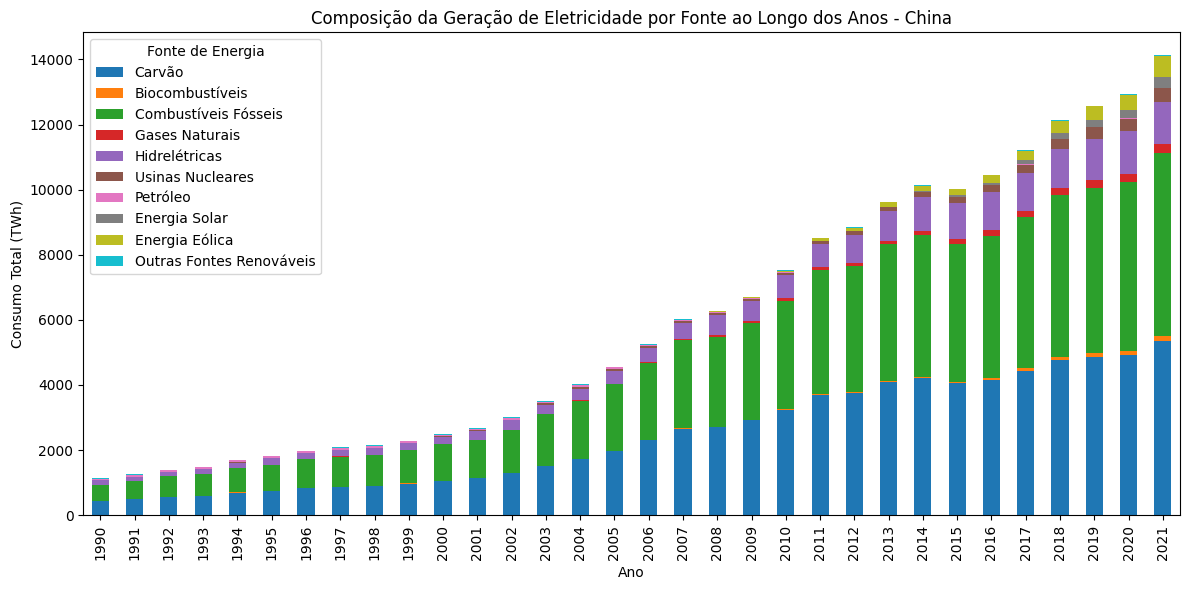

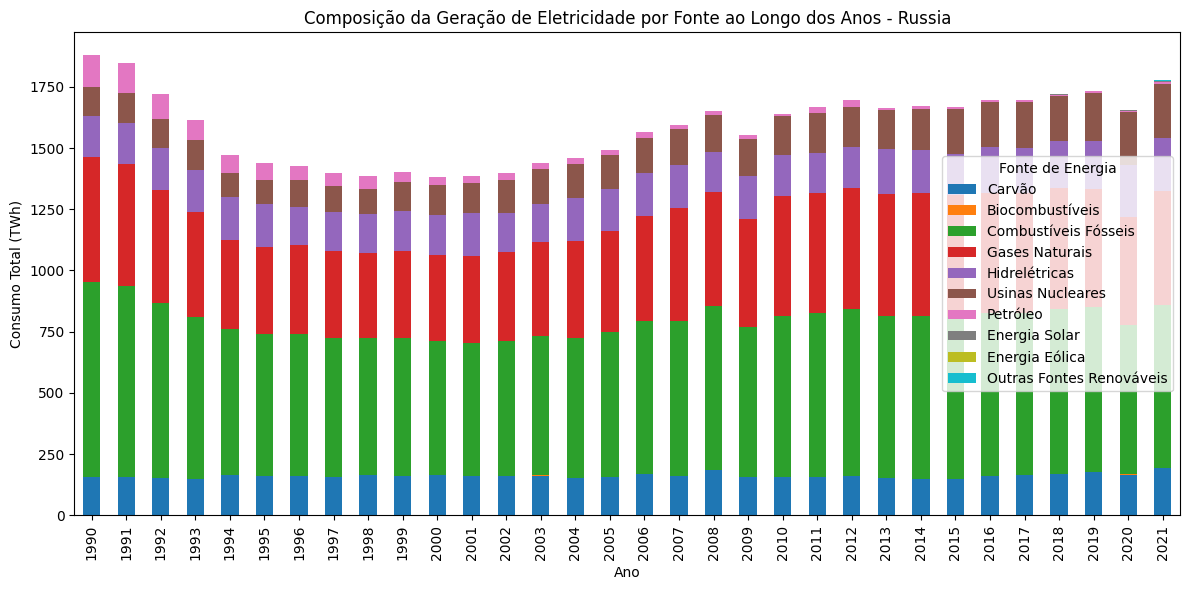

In [15]:
countries = ['Iceland', 'Brazil', 'China', 'Russia']

df_grouped_country = df.groupby(['country', 'year']).sum().reset_index()

energy_translation = {
    'coal_electricity': 'Carvão',
    'biofuel_electricity': 'Biocombustíveis',
    'fossil_electricity': 'Combustíveis Fósseis',
    'gas_electricity': 'Gases Naturais',
    'hydro_electricity': 'Hidrelétricas',
    'nuclear_electricity': 'Usinas Nucleares',
    'oil_electricity': 'Petróleo',
    'solar_electricity': 'Energia Solar',
    'wind_electricity': 'Energia Eólica',
    'other_renewable_exc_biofuel_electricity': 'Outras Fontes Renováveis'
}

for country in countries:
    df_country = df_grouped_country[df_grouped_country['country'] == country]

    df_country.set_index('year')[[
        'coal_electricity',
        'biofuel_electricity',
        'fossil_electricity',
        'gas_electricity',
        'hydro_electricity',
        'nuclear_electricity',
        'oil_electricity',
        'solar_electricity',
        'wind_electricity',
        'other_renewable_exc_biofuel_electricity'
    ]].rename(columns=energy_translation).plot(kind='bar', stacked=True, figsize=(12, 6))

    plt.title(f'Composição da Geração de Eletricidade por Fonte ao Longo dos Anos - {country}')
    plt.xlabel('Ano')
    plt.ylabel('Consumo Total (TWh)')
    plt.legend(title='Fonte de Energia')
    plt.tight_layout()
    plt.show()

Gráfico 3: comparando os gráficos, percebemos uma diminuição considerável no uso de petróleo para geração de energia, e uma pequena diminuição nas usinas nucleares. Apesar de fontes não renováveis continuarem sendo a maioria no mundo mesmo em 2021, é notável o crescimento da produção de energia através de fontes renováveis, principalmente a energia solar e eólica, que representam 2,3% e 4,0% da produção global, respectivamente.

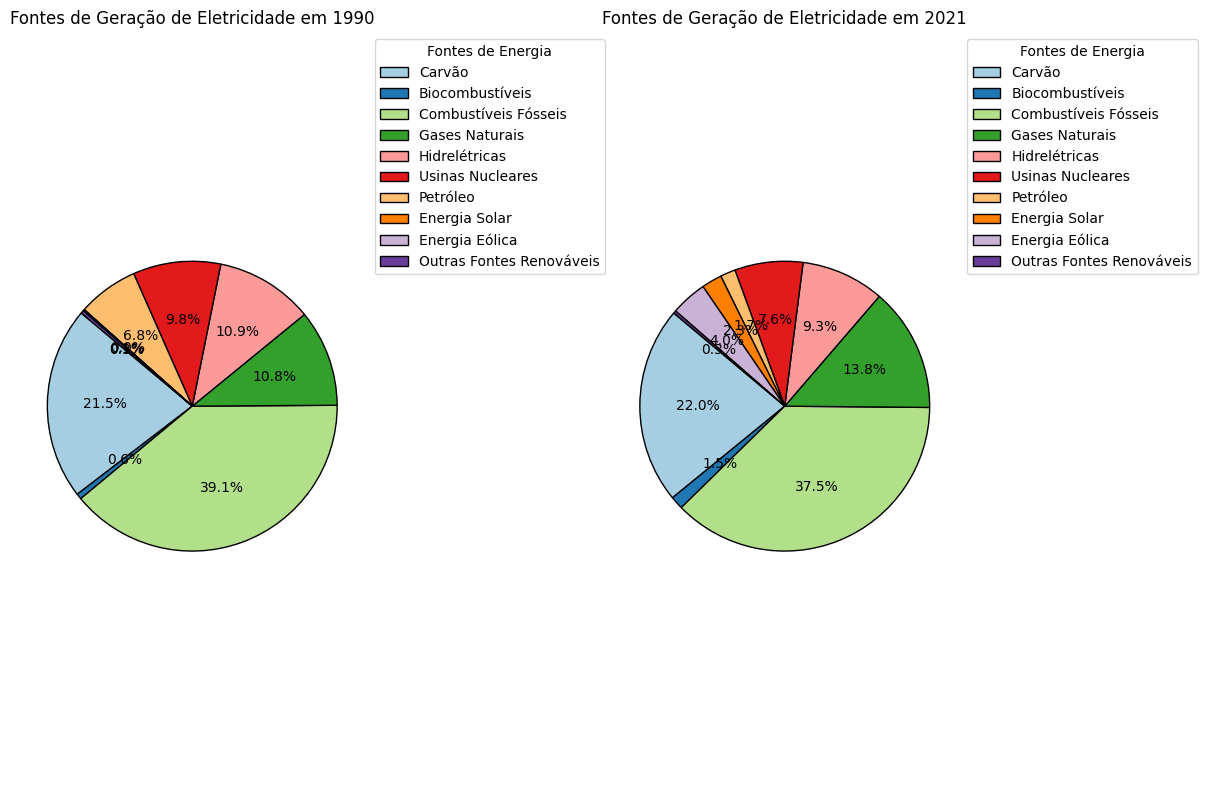

In [16]:
df_1990 = df[df['year'] == 1990].sum()[[
    'coal_electricity',
    'biofuel_electricity',
    'fossil_electricity',
    'gas_electricity',
    'hydro_electricity',
    'nuclear_electricity',
    'oil_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_exc_biofuel_electricity'
]]

df_2021 = df[df['year'] == 2021].sum()[[
    'coal_electricity',
    'biofuel_electricity',
    'fossil_electricity',
    'gas_electricity',
    'hydro_electricity',
    'nuclear_electricity',
    'oil_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_exc_biofuel_electricity'
]]

labels = [
    'Carvão',
    'Biocombustíveis',
    'Combustíveis Fósseis',
    'Gases Naturais',
    'Hidrelétricas',
    'Usinas Nucleares',
    'Petróleo',
    'Energia Solar',
    'Energia Eólica',
    'Outras Fontes Renováveis'
]

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.pie(df_1990, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})
plt.title('Fontes de Geração de Eletricidade em 1990')
plt.legend(labels=labels, title="Fontes de Energia", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.pie(df_2021, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})
plt.title('Fontes de Geração de Eletricidade em 2021')
plt.legend(labels=labels, title="Fontes de Energia", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')

plt.tight_layout()
plt.show()

Gráfico 4: Percebemos que, por grande influência de China, Índia e Russia, a Ásia lidera de forma unânime em quantidade de emissão de carbono gerado a partir da produção de energia.

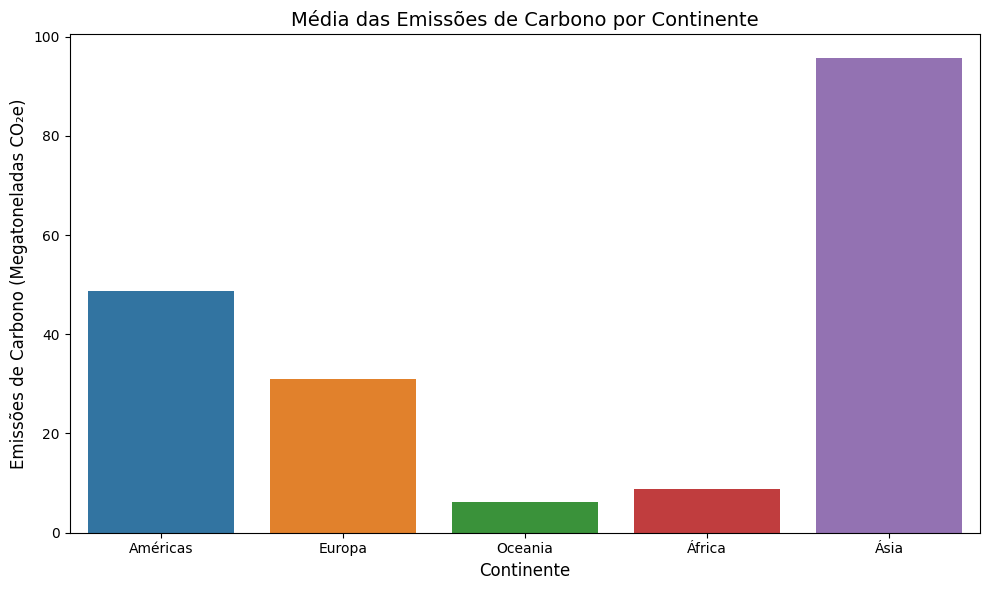

In [17]:
plt.figure(figsize=(10, 6))

df_mean_emissions = df.groupby('continent')['greenhouse_gas_emissions'].mean().reset_index()
sns.barplot(data=df_mean_emissions, x='continent', y='greenhouse_gas_emissions', hue='continent')
plt.title('Média das Emissões de Carbono por Continente', fontsize=14)
plt.xlabel('Continente', fontsize=12)
plt.ylabel('Emissões de Carbono (Megatoneladas CO₂e)', fontsize=12)
plt.tight_layout()
plt.show()

Gráfico 5: podemos perceber que a População não é um fator decisivo para o aumento de emissões de carbono. Por mais que quanto mais pessoas, maior a energia necessária para suprir a necessidade de mais seres humanos, tudo irá depender do tipo de fonte utilizada na produção da energia.

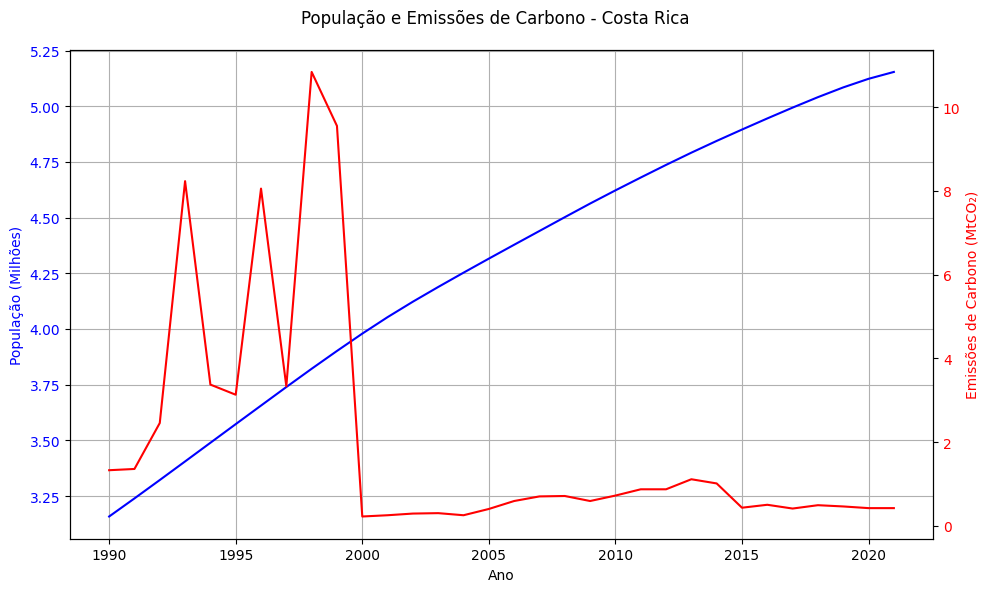

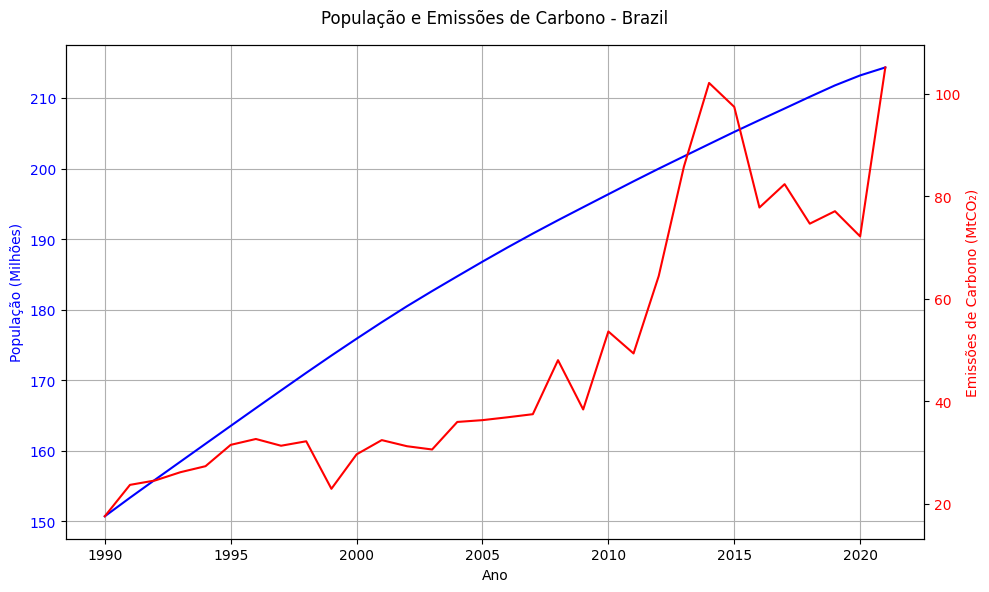

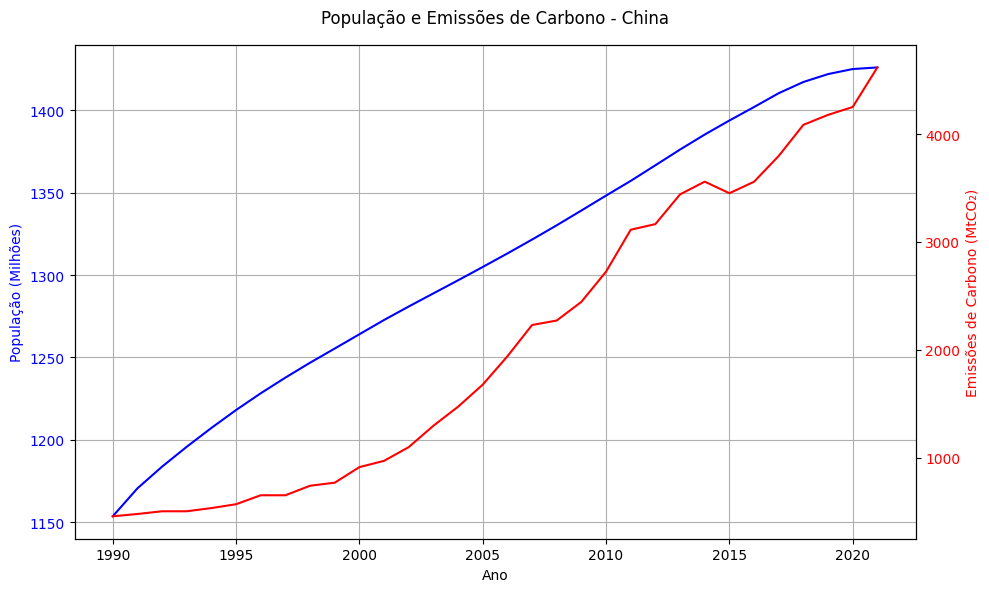

In [18]:
countries = ['Costa Rica', 'Brazil', 'China']

for country in countries:
    df_country = df_grouped_country[df_grouped_country['country'] == country]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(df_country['year'], df_country['population'] / 1e6, color='blue', label='População (milhões)')
    ax1.set_xlabel('Ano')
    ax1.set_ylabel('População (Milhões)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df_country['year'], df_country['greenhouse_gas_emissions'], color='red', label='Emissões (MtCO₂)')
    ax2.set_ylabel('Emissões de Carbono (MtCO₂)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.suptitle(f'População e Emissões de Carbono - {country}')
    ax1.grid(True)
    fig.tight_layout()
    plt.show()

## Treinamento do Modelo de RandomForestRegressor

O modelo de regressão será utilizado para que, a partir dos valores de produção de energia de fontes renováveis e não renováveis, possamos prever qual será a emissão de gás carbono.

Dividindo as variáveis

In [19]:
X_reg = df.drop(columns=['greenhouse_gas_emissions', 'country', 'year', 'population', 'continent', 'electricity_generation'])
y_reg = df['greenhouse_gas_emissions']

scaler = StandardScaler()
X_reg = scaler.fit_transform(X_reg)

Treinando o Modelo

In [20]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

model_regressor = RandomForestRegressor(random_state=42)
model_regressor.fit(X_train_reg, y_train_reg)

y_pred_reg = model_regressor.predict(X_test_reg)
print("Mean Squared Error (MSE):", mean_squared_error(y_test_reg, y_pred_reg))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_reg, y_pred_reg, squared=False))
print("R² Score:", r2_score(y_test_reg, y_pred_reg))

Mean Squared Error (MSE): 225.2055251935223
Root Mean Squared Error (RMSE): 15.006849276031339
R² Score: 0.9924701460174473


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gráfico de dispersão para o modelo de regressão

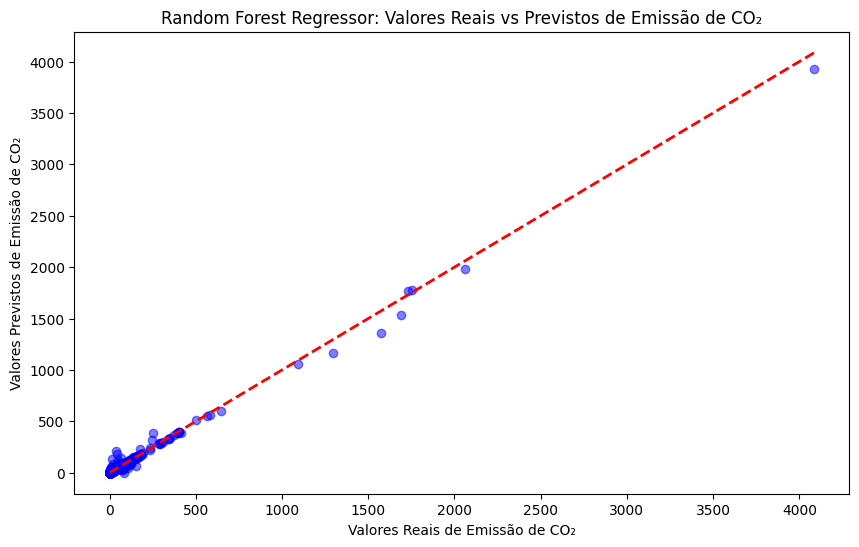

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5, color='b')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel("Valores Reais de Emissão de CO₂")
plt.ylabel("Valores Previstos de Emissão de CO₂")
plt.title("Random Forest Regressor: Valores Reais vs Previstos de Emissão de CO₂")
plt.show()

## Treinamento do Modelo de RandomForestClassifier

O modelo de classificação será utilizado para, com base na produção energia proveniente de fontes renováveis e não renováveis, a emissão de carbono e a população, prevermos a que Continente pertence.

Dividindo as variáveis

In [28]:
X_class = df.drop(columns=['country', 'continent', 'year', 'electricity_generation'])
y_class = df['continent']

# Codificando a variável 'country' como numérica para classificação
label_encoder = LabelEncoder()
y_class = label_encoder.fit_transform(y_class)

scaler = StandardScaler()
X_class = scaler.fit_transform(X_class)

Treinando o modelo

In [31]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.25, random_state=807)

model_classifier = RandomForestClassifier(random_state=707)
model_classifier.fit(X_train_class, y_train_class)

y_pred_class = model_classifier.predict(X_test_class)

Resultados

In [32]:
print("Accuracy Score:", accuracy_score(y_test_class, y_pred_class))

unique_labels = np.unique(y_test_class)
print("Classification Report:\n", classification_report(y_test_class, y_pred_class, labels=unique_labels, target_names=label_encoder.inverse_transform(unique_labels)))
print("Matriz de Confusão:\n", confusion_matrix(y_test_class, y_pred_class))

Accuracy Score: 0.8834771886559802
Classification Report:
               precision    recall  f1-score   support

    Américas       0.86      0.80      0.83       281
      Europa       0.95      0.99      0.97       343
     Oceania       0.85      0.89      0.87       157
      África       0.86      0.86      0.86       470
        Ásia       0.88      0.88      0.88       371

    accuracy                           0.88      1622
   macro avg       0.88      0.88      0.88      1622
weighted avg       0.88      0.88      0.88      1622

Matriz de Confusão:
 [[225   8  13  23  12]
 [  4 338   1   0   0]
 [  8   0 139  10   0]
 [ 20   8   6 405  31]
 [  5   3   4  33 326]]


## Baixando os modelos

Salvando o modelo treinado de regressão

In [33]:
joblib.dump(model_regressor, 'random_forest_model_regression.pkl')

['random_forest_model_regression.pkl']

Salvando o modelo treinado de classificação

In [34]:
joblib.dump(model_classifier, 'random_forest_model_classification.pkl')

['random_forest_model_classification.pkl']